#### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import jax

In [2]:
from jax import vmap
import jax.numpy as jnp
import jax.random as jr
import copy
import matplotlib.pyplot as plt
from dynamax.slds.models import SLDS
from dynamax.slds.test_models import simulate_slds
from dynamax.slds.laplace import laplace_approximation, block_tridiag_mvn_sample
from tensorflow_probability.substrates import jax as tfp
from dynamax.utils.plotting import plot_states_and_timeseries
tfd = tfp.distributions
tfb = tfp.bijectors
MVN = tfd.MultivariateNormalFullCovariance

### Simulate data

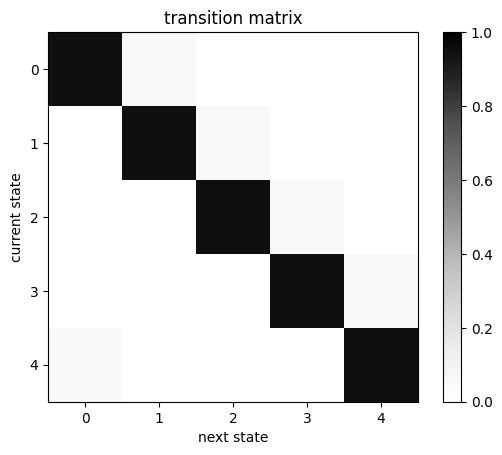

In [3]:
# initialize random number generator
key = jr.PRNGKey(0)

# Make a transition matrix
num_states = 5
p = (jnp.arange(num_states)**10).astype(float)
p /= p.sum()
P = jnp.zeros((num_states, num_states))
for k, p in enumerate(p[::-1]):
    P += jnp.roll(p * jnp.eye(num_states), k, axis=1)

plt.imshow(P, vmin=0, vmax=1, cmap="Greys")
plt.xlabel("next state")
plt.ylabel("current state")
plt.title("transition matrix")
plt.colorbar()

In [4]:
# Make dynamics distributions
latent_dim = 2
rot = lambda theta: jnp.array([[jnp.cos(theta), -jnp.sin(theta)],
                               [jnp.sin(theta), jnp.cos(theta)]])

angles = jnp.linspace(0, 2 * jnp.pi, num_states, endpoint=False)
theta = -jnp.pi / 25 # rotational frequency
As = jnp.array([0.8 * rot(theta) for _ in range(num_states)])
bs = jnp.column_stack([jnp.cos(angles), jnp.sin(angles)])
Qs = jnp.tile(0.001 * jnp.eye(latent_dim), (num_states, 1, 1))

# Compute the stationary points for plotting
stationary_points = jnp.linalg.solve(jnp.eye(latent_dim) - As, bs)

In [5]:
# Make emission distribution
emission_dim = 10
k1, key = jr.split(key)
C = jr.normal(k1, (emission_dim, latent_dim))
d = jnp.zeros(emission_dim)
R = jnp.eye(emission_dim)

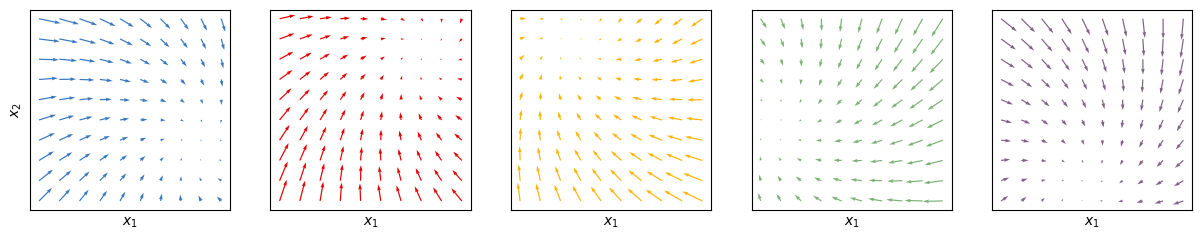

In [6]:
# Plot the dynamics
from dynamax.utils.plotting import COLORS as colors
from dynamax.utils.plotting import CMAP as cmap

lim = 5
x = jnp.linspace(-lim, lim, 10)
y = jnp.linspace(-lim, lim, 10)
X, Y = jnp.meshgrid(x, y)
xy = jnp.column_stack((X.ravel(), Y.ravel()))

fig, axs = plt.subplots(1, num_states, figsize=(3 * num_states, 6))
for k in range(num_states):
    A, b = As[k], bs[k]
    dxydt_m = xy.dot(A.T) + b - xy
    axs[k].quiver(xy[:, 0], xy[:, 1],
                dxydt_m[:, 0], dxydt_m[:, 1],
                color=colors[k % len(colors)])


    axs[k].set_xlabel('$x_1$')
    axs[k].set_xticks([])
    if k == 0:
        axs[k].set_ylabel("$x_2$")
    axs[k].set_yticks([])
    axs[k].set_aspect("equal")

### Pack an SLDSParams object with these simulated parameters

In [7]:
from dynamax.slds.models import SLDSParams

In [8]:
# Pack an SLDSParams object
pi0 = jnp.ones(num_states) / num_states
params = SLDSParams(pi0, P, As, bs, Qs, C, d, R)

# Instantiate the model
slds = SLDS(num_states, latent_dim, emission_dim, params)

# Sample the model with these params
key = jr.PRNGKey(0)
num_timesteps = 10000
zs, xs, ys = slds.sample(key, num_timesteps)

### Plot data sampled from the SLDS

Text(0.5, 1.0, 'latent states')

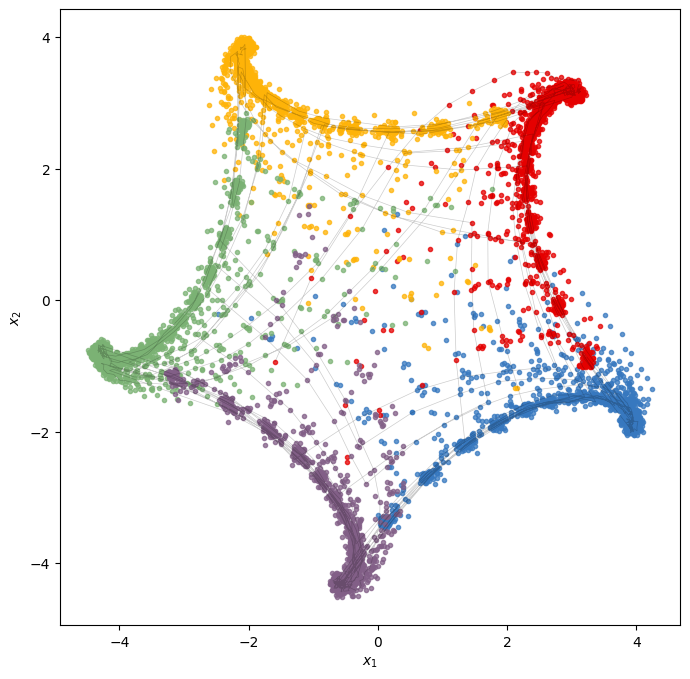

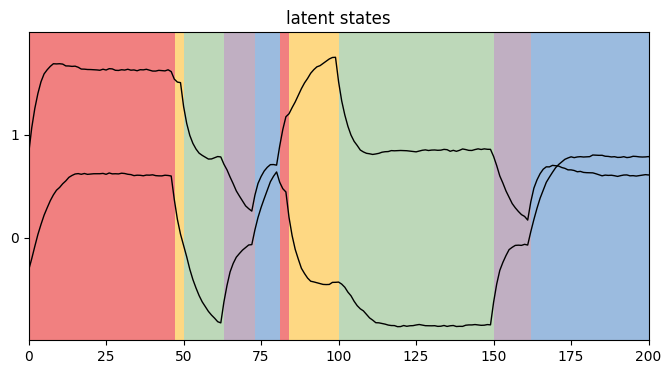

In [10]:
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*xs[zs==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
plt.plot(*xs[:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

fig, ax = plot_states_and_timeseries(zs, xs)
ax.set_xlim(0, 200)
ax.set_title("latent states")

In [61]:
import jax
from dynamax import hidden_markov_model as hmm
from jax.nn import one_hot
from dynamax.utils.utils import fit_linear_regression
import dataclasses

def _fit_laplace_em(slds, key, emissions, initial_zs, initial_xs,
                    num_iters=100, n_discrete_samples=1):
    """
    Estimate the parameters of the SLDS and an approximate posterior distr.
    over latent states using Laplace EM. Specifically, the approximate
    posterior factors over discrete and continuous latent states. The
    discrete state posterior is a discrete chain graph, and the continuous
    posterior is a linear Gaussian chain. We estimate the continuous posterior
    using a Laplace approximation, which is appropriate when the likelihood
    is log concave in the continuous states.
    """
    K = slds.num_states
    D = slds.latent_dim
    N = slds.emission_dim
    ys = emissions
    T = ys.shape[0]

    def _update_discrete_states(key, J_diag, J_lower_diag, h):
        """
        Update the discrete states to the coordinate-wise maximum using the
        Viterbi algorithm.
        """
        # sample xs from q(x)
        key, *skeys = jr.split(key, n_discrete_samples+1)
        vmap_block_tridiag_mvn_sample = vmap(block_tridiag_mvn_sample, in_axes=(0, None, None, None))
        x_samples = vmap_block_tridiag_mvn_sample(jnp.array(skeys), J_diag, J_lower_diag, h)

        pi0 = jnp.mean(jnp.array(
            [slds.params.pi0
                for x in x_samples]), axis=0)

        # TODO: eventually, transition matrix will depend on x
        P = jnp.mean(jnp.array(
            [slds.params.transition_matrix
                for x in x_samples]), axis=0)

        # TODO: change this to call dynamics distribution
        def _dynamics_likelihood(xs):
            As = slds.params.dynamics_matrices   # (K, D, D)
            bs = slds.params.dynamics_biases     # (K, D)
            Qs = slds.params.dynamics_covs       # (K, D, D)
            means = jnp.einsum('kde,te->tkd', As, xs[:-1]) + bs
            log_likes = MVN(means, Qs).log_prob(xs[1:][:, None, :]) # (T-1, K)
            # Account for the first timestep
            log_likes = jnp.vstack([
                slds.init_continuous_state_distn().log_prob(xs[0]) * jnp.ones((1, K)),
                log_likes])
            return log_likes
        vmap_dynamics_likelihood = vmap(_dynamics_likelihood)

        log_likes = jnp.mean(vmap_dynamics_likelihood(x_samples), axis=0)

        return hmm.inference.hmm_smoother(pi0, P, log_likes)

    def _update_continuous_states(ys, zs, xs):

        # Define log prob functions that close over zs and
        log_prob = lambda xs, ys: slds.log_prob(ys, zs, xs) #TODO get access to data

        # TODO : change these to slds object distributions
        # TODO : marginalize over q(z)
        initial_distribution = lambda x0: slds.init_continuous_state_distn().log_prob(x0)
        dynamics_distribution = lambda t, xt, xtp1: slds.dynamics_distn(zs[t+1], xt).log_prob(xtp1)
        emission_distribution = lambda t, xt, yt: slds.emission_distn(xt).log_prob(yt)
        log_normalizer, Ex, ExxT, ExxnT, J_diag, J_lower_diag, h = \
            laplace_approximation(log_prob,
                                initial_distribution,
                                dynamics_distribution,
                                emission_distribution,
                                jnp.zeros_like(xs),
                                ys,
                                method="L-BFGS",
                                num_iters=50)

        return Ex, ExxT, ExxnT, J_diag, J_lower_diag, h

    def _update_params(zs, xs):

        # Currently, initial state distn is fixed
        pi0 = slds.params.pi0

        # Update the discrete state
        zsoh = one_hot(zs, K)
        P = jnp.einsum('ti,tj->ij', zsoh[:-1], zsoh[1:])
        P /= P.sum(axis=1, keepdims=True)

        # Update the dynamics parameters
        xs_pad = jnp.column_stack([xs, jnp.ones((T, 1))])
        ExpxpT = jnp.einsum('tk,td,te->kde', zsoh[1:], xs_pad[:-1], xs_pad[:-1])
        ExpxT = jnp.einsum('tk,td,te->kde', zsoh[1:], xs_pad[:-1], xs[1:])
        ExxT = jnp.einsum('tk,td,te->kde', zsoh[1:], xs[1:], xs[1:])
        Ns = jnp.einsum('tk->k', zsoh[1:])
        Abs, Qs = vmap(fit_linear_regression)(ExpxpT, ExpxT, ExxT, Ns)
        As, bs = Abs[..., :-1], Abs[..., -1]

        # Update emission parameters
        ExxT = jnp.einsum('td,te->de', xs_pad, xs_pad)
        ExyT = jnp.einsum('td,tn->dn', xs_pad, ys)
        EyyT = jnp.einsum('tm,tn->mn', ys, ys)
        Cd, R = fit_linear_regression(ExxT, ExyT, EyyT, T)
        C, d = Cd[..., :-1], Cd[..., -1]

        # Return updated dataclass of parameters
        slds.params = dataclasses.replace(slds.params,
                                    pi0 = pi0,
                                    transition_matrix=P,
                                    dynamics_matrices=jnp.zeros_like(As),
                                    dynamics_biases=bs,
                                    dynamics_covs=Qs,
                                    emission_matrix=C,
                                    emission_bias=d,
                                    emission_cov=R
                                    )
        return

    def _step(carry, args):
        zs, xs, key = carry
        Ex, ExxT, ExxnT, J_diag, J_lower_diag, h = _update_continuous_states(ys, zs, xs)
        xs = Ex # redefine xs as mean
        key, skey = jr.split(key)
        post = _update_discrete_states(skey, J_diag, J_lower_diag, h)
        zs = jnp.argmax(post.smoothed_probs, axis=1)
        _update_params(zs, xs)
        lp = slds.log_prob(ys, zs, xs)
        return (zs, xs, key), lp

    initial_carry = (initial_zs, initial_xs, key)
    (zs, xs, key), lps = jax.lax.scan(_step, initial_carry, None, length=num_iters)

    return lps, zs, xs, key

### Fit with Laplace

#### Initialize parameters

In [22]:
import copy
init_params = copy.deepcopy(params)
print(init_params.dynamics_matrices)

[[[ 0.7936918   0.10026659]
  [-0.10026659  0.7936918 ]]

 [[ 0.7936918   0.10026659]
  [-0.10026659  0.7936918 ]]

 [[ 0.7936918   0.10026659]
  [-0.10026659  0.7936918 ]]

 [[ 0.7936918   0.10026659]
  [-0.10026659  0.7936918 ]]

 [[ 0.7936918   0.10026659]
  [-0.10026659  0.7936918 ]]]


In [62]:
test_slds = SLDS(num_states, latent_dim, emission_dim, init_params)
lps, fit_zs, fit_xs, final_key = _fit_laplace_em(test_slds,
    jr.PRNGKey(0), ys, zs, xs, num_iters=10, n_discrete_samples=1)

assert jnp.all(jnp.isfinite(lps))

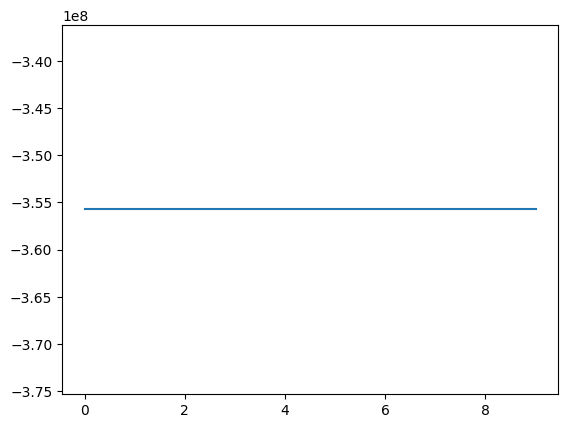

In [63]:
plt.plot(lps)

Text(0.5, 1.0, 'true latent states')

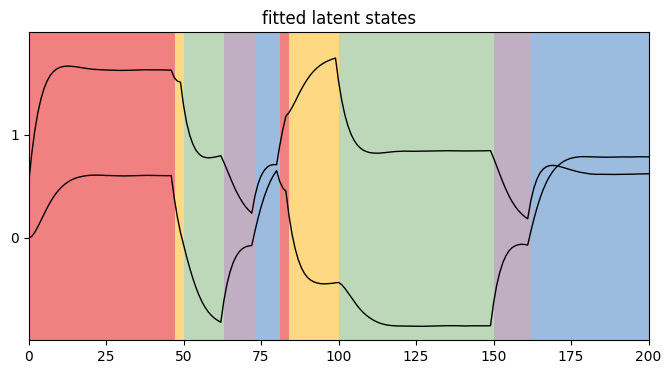

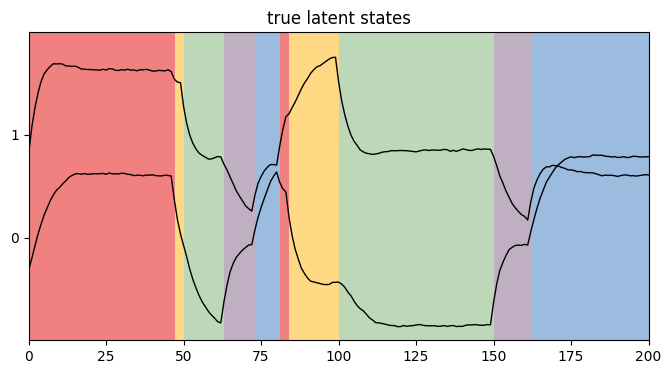

In [64]:
fig, ax = plot_states_and_timeseries(fit_zs, fit_xs)
ax.set_xlim(0, 200)
ax.set_title("fitted latent states")

fig, ax = plot_states_and_timeseries(zs, xs)
ax.set_xlim(0, 200)
ax.set_title("true latent states")

### Test whether dataclasses.replace works on the method

In [32]:
new_pi0 = jnp.array([0.2, 0.3, 0.1, 0.4])
new_slds_params = dataclasses.replace(test_slds.params,
                                             pi0 = new_pi0)

In [33]:
new_slds_params

SLDSParams(pi0=Array([0.2, 0.3, 0.1, 0.4], dtype=float32), transition_matrix=Traced<ShapedArray(float32[5,5])>with<DynamicJaxprTrace(level=1/0)>, dynamics_matrices=Traced<ShapedArray(float32[5,2,2])>with<DynamicJaxprTrace(level=1/0)>, dynamics_biases=Traced<ShapedArray(float32[5,2])>with<DynamicJaxprTrace(level=1/0)>, dynamics_covs=Traced<ShapedArray(float32[5,2,2])>with<DynamicJaxprTrace(level=1/0)>, emission_matrix=Traced<ShapedArray(float32[10,2])>with<DynamicJaxprTrace(level=1/0)>, emission_bias=Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>, emission_cov=Traced<ShapedArray(float32[10,10])>with<DynamicJaxprTrace(level=1/0)>)

In [42]:
test_slds.params

SLDSParams(pi0=Array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32), transition_matrix=Traced<ShapedArray(float32[5,5])>with<DynamicJaxprTrace(level=1/0)>, dynamics_matrices=Traced<ShapedArray(float32[5,2,2])>with<DynamicJaxprTrace(level=1/0)>, dynamics_biases=Traced<ShapedArray(float32[5,2])>with<DynamicJaxprTrace(level=1/0)>, dynamics_covs=Traced<ShapedArray(float32[5,2,2])>with<DynamicJaxprTrace(level=1/0)>, emission_matrix=Traced<ShapedArray(float32[10,2])>with<DynamicJaxprTrace(level=1/0)>, emission_bias=Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>, emission_cov=Traced<ShapedArray(float32[10,10])>with<DynamicJaxprTrace(level=1/0)>)

In [35]:
test_slds.params = dataclasses.replace(test_slds.params,
                                             pi0 = new_pi0)

In [37]:
test_slds.params

SLDSParams(pi0=Array([0.2, 0.3, 0.1, 0.4], dtype=float32), transition_matrix=Traced<ShapedArray(float32[5,5])>with<DynamicJaxprTrace(level=1/0)>, dynamics_matrices=Traced<ShapedArray(float32[5,2,2])>with<DynamicJaxprTrace(level=1/0)>, dynamics_biases=Traced<ShapedArray(float32[5,2])>with<DynamicJaxprTrace(level=1/0)>, dynamics_covs=Traced<ShapedArray(float32[5,2,2])>with<DynamicJaxprTrace(level=1/0)>, emission_matrix=Traced<ShapedArray(float32[10,2])>with<DynamicJaxprTrace(level=1/0)>, emission_bias=Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=1/0)>, emission_cov=Traced<ShapedArray(float32[10,10])>with<DynamicJaxprTrace(level=1/0)>)